<a href="https://colab.research.google.com/github/Dina-Nabil/Image-Mosaics/blob/master/Image_Mosaics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Upload Images

In [0]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import random
import imageio
import imutils
from google.colab import files
uploaded = files.upload()

In [0]:
#to plot image
def plot_image(image,color,title):
  plt.rcParams["figure.figsize"] = (20,10)
  plt.grid("false")
  plt.title(title)
  if(color=='colored'):
    plt.imshow(image)
  elif(color=="gray"):
    plt.imshow(image,cmap='gray',interpolation="bicubic")

#to turn from gbr to rgb 
def BGR2RGB(image):
  return cv.cvtColor(image,cv.COLOR_BGR2RGB)

#change to rgb and plot
def read_image(name):
  image = cv.imread(name)
  RGB_image=BGR2RGB(image)
  plot_image(RGB_image,"colored","Image")
  return image

# **Read Images**

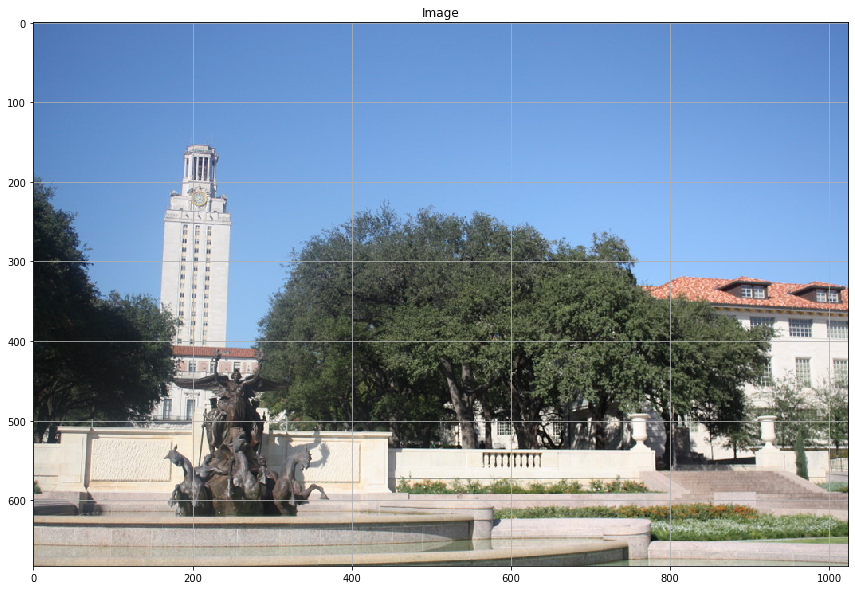

In [0]:
first_view = read_image('1.png')

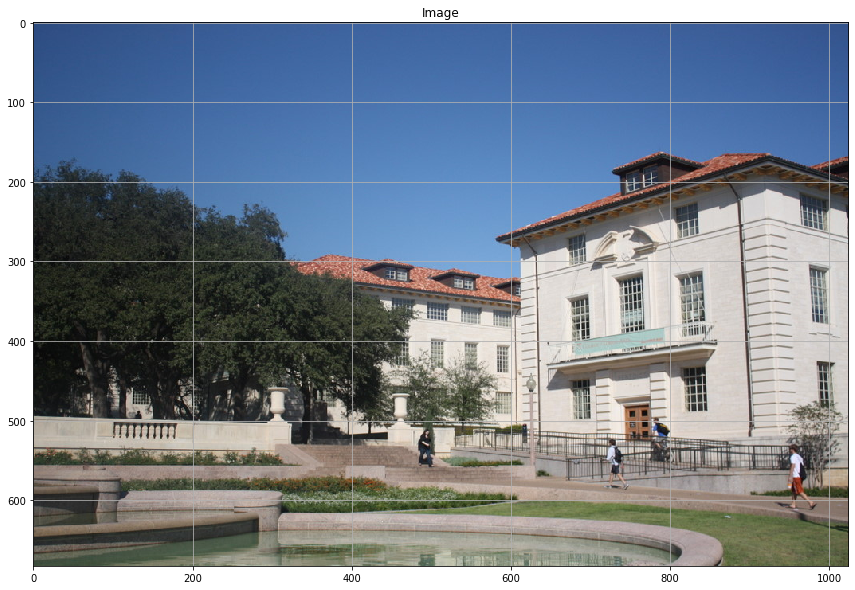

In [0]:
second_view = read_image('2.png')

# **1.1 Getting correspondences**

In [0]:
#based on number of features this method will return key-points and descriptors for the image.
def detect_describe(image):
  orb = cv.ORB_create(nfeatures=10000)
  copy_img=image
  key_pts, descriptors = orb.detectAndCompute(copy_img, None) 
  return key_pts, descriptors 

#used to draw key points green we can change it and we can add another filters to it
def draw_keypoints(image,key_pts):
  copy_img = image
  image_keypoints = cv.drawKeypoints(copy_img,key_pts,copy_img,color=(0,255,0))
  plot_image(BGR2RGB(image_keypoints),"colored","Key Points")

#Used to compare the 2 images to find the matching keypoints using hamming distance."Feature matching" Brute Force matcher
#Brute-Force matcher is simple. It takes the descriptor of one feature in first set and is matched with all other features 
#in second set using some distance calculation. And the closest one is returned.
#used to draw the matching keypoints too. 
def match(image_a,image_b):
  key_pts_a, descriptors_a=detect_describe(image_a)
  key_pts_b, descriptors_b=detect_describe(image_b)
  copy_a=image_a
  copy_b=image_b
  draw_keypoints(copy_a,key_pts_a)
  draw_keypoints(copy_b,key_pts_b)
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  matches = bf.match(descriptors_a, descriptors_b)
  matches = sorted(matches, key = lambda x: x.distance,reverse=0)
  img_matches = cv.drawMatches(image_a, key_pts_a, image_b, key_pts_b, matches[:4], image_b, flags=2)
  plot_image(BGR2RGB(img_matches),"colored","Matching")
  # Initialize arrays
  kps_a = []
  kps_b = []
  matches=matches[:20]
  for match in matches:
    # Get the matching keypoints for each of the images
    img_a_idx = match.queryIdx
    img_b_idx = match.trainIdx
    # Get the coordinates x and y for both 
    (x1,y1) = key_pts_a[img_a_idx].pt
    (x2,y2) = key_pts_b[img_b_idx].pt
    # Append to each list
    kps_a.append((x1, y1))
    kps_b.append((x2, y2))   
  return kps_a , kps_b

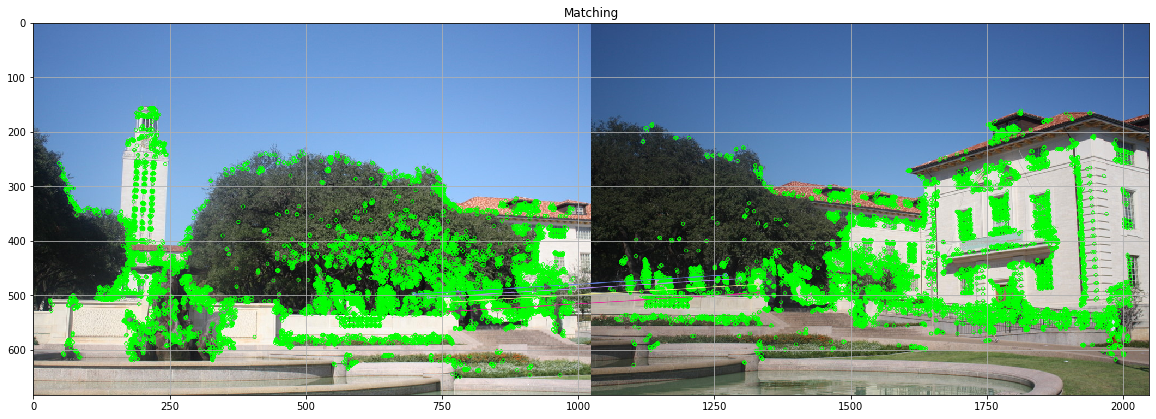

In [0]:
kps_1,kps_2 = match(first_view,second_view)

# **Computing the homography parameters**

In [0]:
def get_coordinates(kps,index):
  point = kps[index]
  return point[0] , point[1]

def get_sub_a_matrix(x,y,x_,y_):
  matrix=np.zeros((2,8))
  matrix[0]=np.array([x, y,1,0,0,0, -x*x_, -y*x_])
  matrix[1]=np.array([0,0,0,x, y,1, -x*y_, -y*y_])
  return matrix

"""
Write a function that takes a set of corresponding image points and computes the associated
3 × 3 homography matrix H. This matrix transforms any point p in one view to its correspond-
ing homogeneous coordinates in the second view, p' , such that p' = Hp.
"""
# https://www.reddit.com/r/computervision/comments/2h1yfj/how_to_calculate_homography_matrix_with_dlt_and/
# http://www.csc.kth.se/~perrose/files/pose-init-model/node17.html
# https://www.learnopencv.com/homography-examples-using-opencv-python-c/  if u want ready function
def get_homography_matrix(kps_a,kps_b):
  n=len(kps_a)
  #build b 
  b = np.zeros(((2*n),1))
  for i in range(n):
    b[2*i], b[2*i +1]=get_coordinates(kps_b,i)
  # build a
  a = np.zeros(((2*n),8))
  for i in range(n):
    x,y=get_coordinates(kps_a,i)
    x_,y_=get_coordinates(kps_b,i)
    sub_a_matrix=get_sub_a_matrix(x,y,x_,y_)
    a[2*i] = sub_a_matrix[0]
    a[2*i + 1] = sub_a_matrix[1]		
  # Solve equations to compute H ,Use two points to get the H.
  H=np.linalg.lstsq(a, b)[0]
  H=np.append(H,1)
  H=np.reshape(H,(3,3))
  return H

In [0]:
H=get_homography_matrix(kps_1,kps_2)
H

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


array([[ 1.05524430e+00, -1.08857683e-01, -4.29882708e+02],
       [ 9.16275796e-02,  9.55206604e-01, -6.45807032e+01],
       [ 1.25417011e-04, -1.22647838e-04,  1.00000000e+00]])

In [0]:
def match(image_a,image_b):
  corres_List = []
  key_pts_a, descriptors_a=detect_describe(image_a)
  key_pts_b, descriptors_b=detect_describe(image_b)
#   copy_a=image_a
#   copy_b=image_b
#   draw_keypoints(copy_a,key_pts_a)
#   draw_keypoints(copy_b,key_pts_b)
  bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
  matches = bf.match(descriptors_a, descriptors_b)
  matches = sorted(matches, key = lambda x: x.distance)
  img_matches = cv.drawMatches(image_a, key_pts_a, image_b, key_pts_b, matches[:4], image_b, flags=2)
  plot_image(BGR2RGB(img_matches),"colored","Matching")
  num_of_req_matches=10
  # Initialize arrays
  kps_a = np.zeros((0,2))
  kps_b = np.zeros((0,2))
  matches=matches[:num_of_req_matches]
  for match in matches:
    # Get the matching keypoints for each of the images
    img_a_idx = match.queryIdx
    img_b_idx = match.trainIdx
    # Get the coordinates
    (x1,y1) = key_pts_a[img_a_idx].pt
    (x2,y2) = key_pts_b[img_b_idx].pt
    # Append to each list
    #############################################################
    corres_List.append([x1, y1, x2, y2]) 
    #############################################################
    kps_a=np.vstack((kps_a,(x1, y1)))
    kps_b=np.vstack((kps_b,(x2, y2))) 
    
  correspoints = np.matrix(corres_List)
 
  return kps_a , kps_b ,correspoints ,matches

[[908.23699951 378.22473145]
 [760.32000732 519.84002686]
 [849.60003662 508.32000732]
 [836.35205078 514.94403076]
 [930.63189697 435.45611572]
 [764.41210938 534.49127197]
 [856.80004883 506.88000488]
 [765.1585083  532.9152832 ]
 [891.64813232 514.25286865]
 [791.28594971 532.50061035]]
[[455.3626709  355.82983398]
 [305.85601807 485.5680542 ]
 [394.56002808 478.08001709]
 [381.88803101 483.84005737]
 [472.78085327 408.49926758]
 [307.556427   501.64544678]
 [400.80001831 476.40002441]
 [308.96643066 499.7376709 ]
 [437.18405151 487.29605103]
 [335.92327881 500.1524353 ]]
hna:corrs  [[908.23699951 378.22473145 455.3626709  355.82983398]
 [760.32000732 519.84002686 305.85601807 485.5680542 ]
 [849.60003662 508.32000732 394.56002808 478.08001709]
 [836.35205078 514.94403076 381.88803101 483.84005737]
 [930.63189697 435.45611572 472.78085327 408.49926758]
 [764.41210938 534.49127197 307.556427   501.64544678]
 [856.80004883 506.88000488 400.80001831 476.40002441]
 [765.1585083  532.915

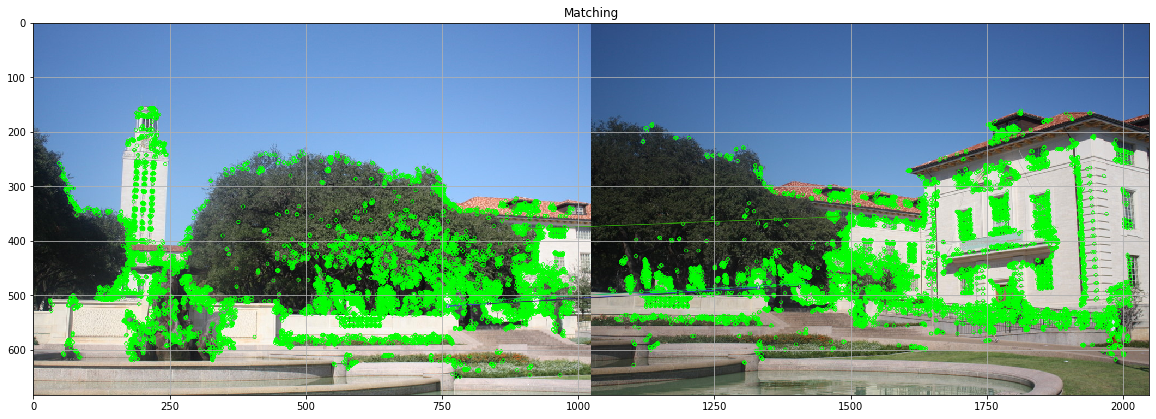

In [0]:
kps_1,kps_2,correspoints,matches = match(first_view,second_view)
print(kps_1)
print(kps_2)
print("hna:corrs ",correspoints)

Verify Homography matrix

In [0]:
#we can use ransac to verify the H matrix by calculating difference built in and calculated.
#there is a built in method to calculate the H matrix in OpenCv we can use it to to compare btwn our H and the Computed H. 
def verify_H(px,py,H):
  a=np.ones((3,1))
  a[0,0]=px
  a[1,0]=py
  b=np.dot(H,a)
  b=b/b[2,0]
  print(b)

In [0]:
verify_H(kps_1[2,0],kps_1[2,1],H)

[[395.53574334]
 [477.45578406]
 [  1.        ]]


# **Functions**

In [0]:
#apply the H transform on point. Homo corrdinates.
def transform(point,H):
  result = np.dot(H, point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result	

#apply the H inv transform on point.
def inv_transform(point,H):
  result = np.dot(np.linalg.inv(H), point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result	

#Wrap image size using the shifts.
def wraped_image_size(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]
  boundaries = np.array([[0,0],[height-1, 0],[0, width-1],[height-1, width-1]])
  i_s =np.zeros(4,dtype=int)
  j_s =np.zeros(4,dtype=int)
  
  for k in range(0,4):
    i = boundaries[k][0]
    j = boundaries[k][1]
    mapped = transform(np.array([[j],[i],[1]]), H)
    j_s[k] = int(mapped[0][0])
    i_s[k] = int(mapped[1][0])
          
  min_mapped_i=np.min(i_s)
  min_mapped_j=np.min(j_s)
  max_mapped_i=np.max(i_s)
  max_mapped_j=np.max(j_s)
   
  new_height = (max_mapped_i-min_mapped_i+1)
  new_width = (max_mapped_j-min_mapped_j+1)
  
  height_shift =-min_mapped_i
  width_shift =-min_mapped_j
  
  return (new_height,new_width,height_shift,width_shift)

#Wrap image using the shifts.
def wrap(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]

  (wraped_image_height,wraped_image_width,height_shift,width_shift)=wraped_image_size(image_a , H)
  wraped_image = np.zeros((wraped_image_height,wraped_image_width,3), dtype=np.uint8);
  
  for i in range(0,image_a.shape[0]):
    for j in range(0,image_a.shape[1]):
      mapped = transform(np.array([[j],[i],[1]]), H)
      mapped_j = int(mapped[0][0])
      mapped_i = int(mapped[1][0])
      wraped_image[mapped_i+height_shift][mapped_j+width_shift] = image_a[i][j]
      
  return (wraped_image,height_shift,width_shift)
#remove holes from image[cased by wrapping]
def remove_holes(wraped_image,H,image_a,height_shift,width_shift):
  height = image_a.shape[0]
  width = image_a.shape[1]
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]
  
  for i in range(0, wraped_image_height):
    for j in range(0, wraped_image_width):
      if int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][1]) == 0 and int(wraped_image[i][j][2]) == 0:
        inv_mapped = inv_transform(np.array([[(j - width_shift)], [(i-height_shift)],[1]]),H)
        inv_mapped_j = inv_mapped[0][0]
        inv_mapped_i = inv_mapped[1][0]
        if inv_mapped_i <= height-1 and  inv_mapped_i >= 0 and inv_mapped_j <= width-1 and inv_mapped_j >= 0:
          index_i = int(inv_mapped_i);
          index_j = int(inv_mapped_j);
          a = inv_mapped_i - index_i;
          b = inv_mapped_j - index_j;
          wraped_image[i][j] = (1-a)*(1-b)*image_a[index_i][index_j]+ a*(1-b)*image_a[index_i+1][index_j]+ a*b*image_a[index_i+1][index_j+1]+ (1-a)*b*image_a[index_i][index_j+1]  
  return wraped_image


def create_mosaic(wraped_image,image_b,height_shift,width_shift):
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]
  image_b_height = image_b.shape[0]
  image_b_width = image_b.shape[1]
  mosaic_height=0
  mosaic_width=0

  # cases for different sizes.
  if wraped_image_height > image_b_height + height_shift :
    mosaic_height = wraped_image_height
  else:
    mosaic_height = image_b_height + height_shift

  if mosaic_width > image_b_width + width_shift:
    mosaic_width = mosaic_width
  else:
    mosaic_width = image_b_width + width_shift

  mosaic = np.zeros((mosaic_height, mosaic_width, 3), dtype=np.uint8)
  
  for i in range(0,image_b_height):
    for j in range(0, image_b_width):
      mosaic[i+height_shift][j+width_shift] = image_b[i][j]
  
  for i in range(0,wraped_image_height):
    for j in range(0, wraped_image_width):
      if not(int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][2]) == 0):
        mosaic[i][j] = wraped_image[i][j]
        
  return mosaic 

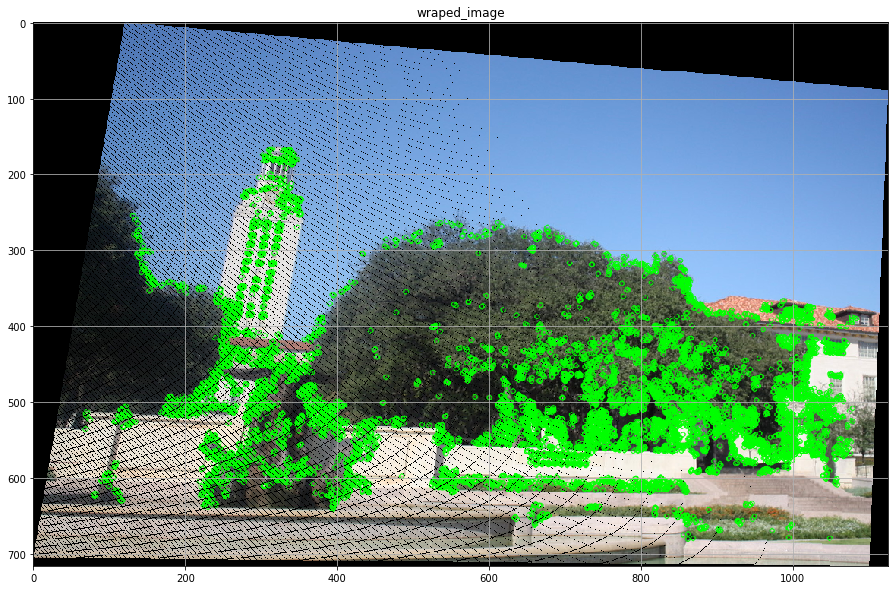

In [0]:
(wraped_image,height_shift,width_shift) = wrap(first_view,H)
plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

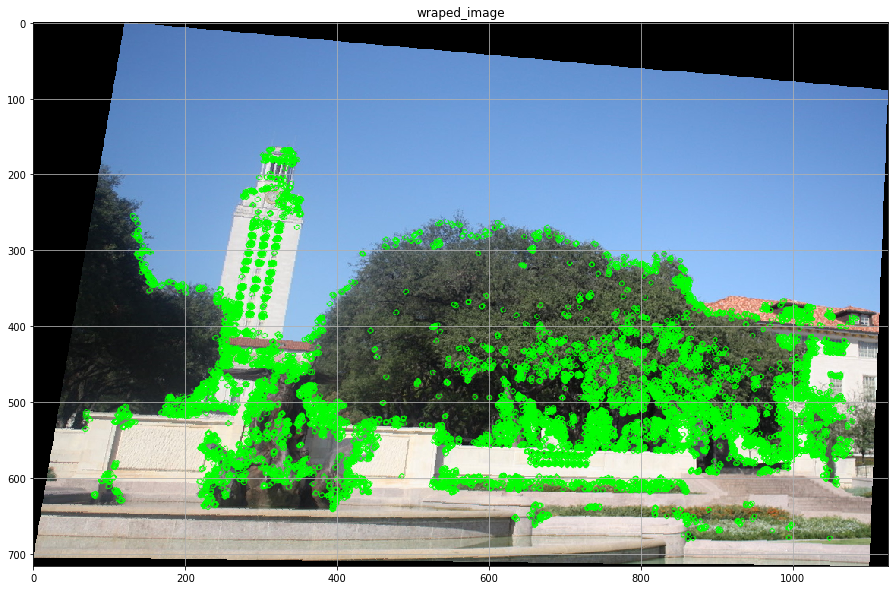

In [0]:
wraped_image=remove_holes(wraped_image,H,first_view,height_shift,width_shift)
plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

# **Final Output**

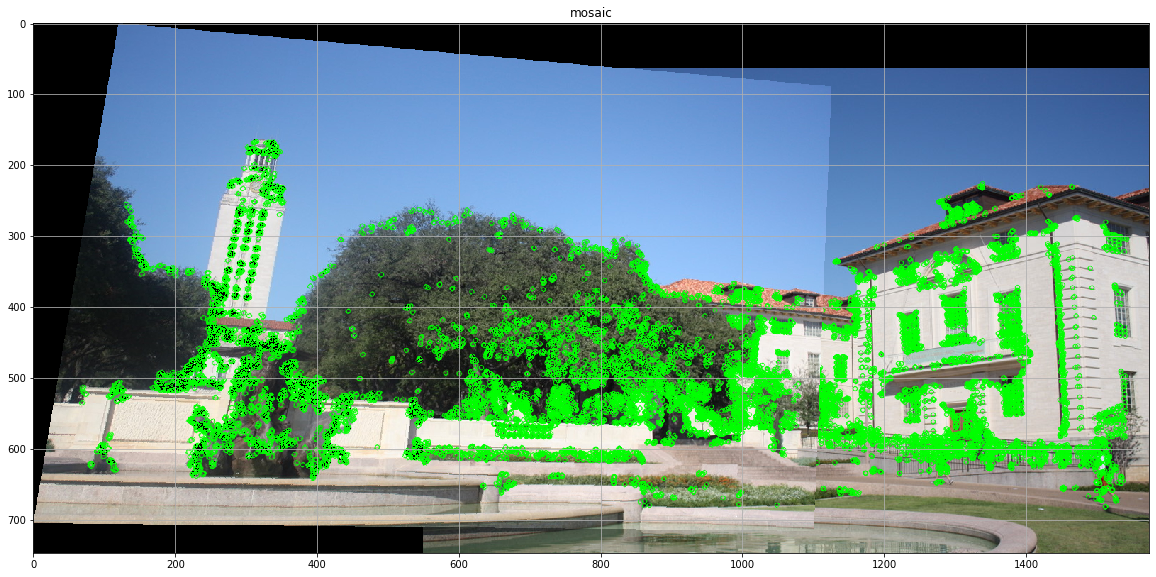

In [0]:
mosaic=create_mosaic(wraped_image,second_view,height_shift,width_shift)
plot_image(BGR2RGB(mosaic),'colored','mosaic')